Predicting NFL Wins

As an avid sports and football fan, most of my football Sundays involve watching the games. With the recent legalization of sports gambling and the growing popularity of platforms like DraftKings, I began to question the accuracy of betting spreads and whether additional factors could improve predictions of game outcomes.

In this project, I aim to develop a machine learning model that predicts the winner of NFL games based on betting spread data and team statistics from previous seasons. A successful model, in my view, would achieve a win prediction accuracy of over 55%, which would be considered profitable in gambling terms (as certain casino games have a house edge of less than 1%).

While the dataset I am using is limited and focuses on team stats and betting spreads from past seasons, the real-world challenge involves many more factors, such as individual player performance, coaching, and strategies. Despite these limitations, I believe the betting spreads, which already incorporate a wealth of data, may still offer useful insights when combined with team stats.

The initial motivation for a deliverable was to calculate the profit or loss the model would generate during a given season. However, due to limited access to historical betting data, I decided to shift the focus to win prediction for now. I will continue to expand my datasets and improve the model, with the hope of incorporating it into my fantasy drafts in the upcoming years.

I secured all of my data from Pro Football reference (Sports Reference LLC. (n.d.). Pro Football Reference. Retrieved [03/01/25], from https://www.pro-football-reference.com/). I also saved some time with data cleaning by utilizing a spread data created on a Kaggle data souce here (https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data). Modern games are missing betting data, which are available on sportsline.com and aussportsbetting.com, starting from 2013. I have been gathering data, but it has been a slow process but I will eventually update the data set and the model

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier


In [2]:
spread_df = pd.read_csv("data/spreadspoke_scores.csv")
spread_df = spread_df[spread_df['schedule_season'] >= 1978].reset_index(drop=True)

print(spread_df.columns)

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'weather_detail'],
      dtype='object')


We load our first dataset into a DataFrame. This dataset contains NFL game information, the spread between the teams, as well as the over/under line for each game, among other features. I decided to include only games starting from 1978, as the older games (pre-1978) lack data. I also decided to exclude the weather data for now, as I ran into issues scraping consistent weather data. Since I already have access to a large number of feature sets, I have included some of the weather data that I was able to scrape so far and plan on adding more to the dataset and model in the future.

In [3]:
spread_df = spread_df.drop(columns = ['weather_humidity', 'weather_detail', 'weather_wind_mph', 'weather_temperature', 'stadium_neutral'])
print(spread_df.columns)

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium'],
      dtype='object')


The data that I was able to secure for team's season's stat only includes offensive stats. However, Points Against (PA) for each team in a season could be calculated from the spread data, so I decided to do so below.

In [4]:
papf_df = pd.read_csv("data/spreadspoke_scores.csv")
papf_df = papf_df[papf_df['schedule_season'] >= 1978].reset_index(drop=True)
papf_df = papf_df[papf_df['schedule_playoff'] != True].reset_index(drop=True)

points_for = {}
points_against = {}

for index, row in papf_df.iterrows():
    home_team = row['team_home']
    away_team = row['team_away']
    home_score = row['score_home']
    away_score = row['score_away']
    season = row['schedule_season']
    
    if (season, home_team) not in points_for:
        points_for[(season, home_team)] = 0
    points_for[(season, home_team)] += home_score
    
    if (season, away_team) not in points_for:
        points_for[(season, away_team)] = 0
    points_for[(season, away_team)] += away_score

    if (season, home_team) not in points_against:
        points_against[(season, home_team)] = 0
    points_against[(season, home_team)] += away_score

    if (season, away_team) not in points_against:
        points_against[(season, away_team)] = 0
    points_against[(season, away_team)] += home_score

points_for_df = pd.DataFrame(list(points_for.items()), columns=['Season_Team', 'PF'])
points_against_df = pd.DataFrame(list(points_against.items()), columns=['Season_Team', 'PA'])

points_for_df[['Season', 'Team']] = pd.DataFrame(points_for_df['Season_Team'].tolist(), index=points_for_df.index)
points_against_df[['Season', 'Team']] = pd.DataFrame(points_against_df['Season_Team'].tolist(), index=points_against_df.index)

points_for_df = points_for_df.drop(columns=['Season_Team'])
points_against_df = points_against_df.drop(columns=['Season_Team'])



Next, I load all of the team stats (separated by season) into a dictionary to utilize later in combinding the tables,

In [5]:
teamstat_csv = glob.glob(os.path.join("data/team stats", "*.csv"))
season_stat = {}
correct_headers = [
    'Rk', 'Tm', 'G', 'PF', 'Tot_Yds', 'Ply', 'Y/P', 'TO', 'FL', '1stD',
    'Cmp', 'Att', 'Passing_Yds', 'Passing_TD', 'Passing_Int', 'NY/A', 'Passing_1stD',
    'Rushing_Att', 'Rushing_Yds', 'Rushing_TD', 'Y/A', 'Rushing_1stD', 'Pen', 
    'Pen_Yds', '1stPy', 'Sc%', 'TO%'
]

points_against_df['Season'] = points_against_df['Season'].astype(int)

for csv in teamstat_csv:
    year = int(os.path.splitext(os.path.basename(csv))[0]) 
    df = pd.read_csv(csv, header=1)

    if len(df.columns) > len(correct_headers):
        df = df.iloc[:, :len(correct_headers)]
    
    df.columns = correct_headers 
    season_pa = points_against_df[points_against_df['Season'] == year].reset_index(drop=True)

    df = df.merge(season_pa, how='left', left_on='Tm', right_on='Team').drop(columns=['Season', 'Team'])
    season_stat[year] = df 

print(season_stat)

{1978:     Rk                    Tm   G   PF  Tot_Yds   Ply  Y/P  TO  FL  1stD  ...  \
0    1        Dallas Cowboys  16  384     5959  1107  5.4  35  18   342  ...   
1    2        Miami Dolphins  16  372     4835   954  5.1  30  12   270  ...   
2    3         New York Jets  16  359     4857   993  4.9  37   9   277  ...   
3    4  New England Patriots  16  358     5965  1085  5.5  46  21   322  ...   
4    5   Pittsburgh Steelers  16  356     4996  1046  4.8  39  17   316  ...   
5    6    San Diego Chargers  16  355     5471  1099  5.0  51  21   315  ...   
6    7      Seattle Seahawks  16  345     5511  1072  5.1  41  19   345  ...   
7    8      Cleveland Browns  16  334     5347  1036  5.2  50  29   293  ...   
8    9      Los Angeles Rams  16  316     5182  1109  4.7  44  22   301  ...   
9   10       Oakland Raiders  16  311     4913  1049  4.7  43  12   309  ...   
10  11         Buffalo Bills  16  302     4630   974  4.8  34  17   274  ...   
11  12     Minnesota Vikings  16 

Next, we remove some unnecessary features from the table. Features such as total yards, total plays, yards per play are unnecessary since they are derived from existing columns in the table. By same logic, pass and rush attempts can be ommited as well.

In [6]:
columns_to_drop = ['Rk', 'Tot_Yds', 'Ply', 'Y/P', '1stD', 'Cmp', 'Rushing_Att']

for year, df in season_stat.items():
    season_stat[year] = df.drop(columns=columns_to_drop)
 

An interesting point to note is that, starting around the mid-1990s, passing yardage and total yardage seem to increase over time. This trend appears to be consistent with a major rule change that the NFL introduced in 1994. It might be important to consider that games before 1994 may hold different weight in modern games.

In [7]:
season_totals = []

for year, df in season_stat.items():
    total_games = df['G'].sum()
    season_totals.append({
        'Season': year,
        'Passing_Yards': df['Passing_Yds'].sum()/total_games,
        'Rushing_Yards': df['Rushing_Yds'].sum()/total_games,
        'Total_Yards':df['Passing_Yds'].sum()/total_games + df['Rushing_Yds'].sum()/total_games,
    })

season_df = pd.DataFrame(season_totals).sort_values(by='Season')

plt.figure(figsize=(12, 6))
plt.plot(season_df['Season'], season_df['Passing_Yards'] + season_df['Rushing_Yards'], label='Total Yards', color='blue')
plt.plot(season_df['Season'], season_df['Passing_Yards'], label='Passing Yards', color='green')
plt.plot(season_df['Season'], season_df['Rushing_Yards'], label='Rushing Yards', color='red')

plt.xlabel("Season")
plt.ylabel("Yards")
plt.title("Evolution of Total, Passing, and Rushing Yards Over Time")
plt.legend()
plt.grid()
plt.show()

Since the general trend of increased offense is apparent, I decided to normalize each stat to its respective season's average.

In [337]:
for year, df in season_stat.items():

    df = df.copy()
    df[df.columns.difference(['Tm'])] = df[df.columns.difference(['Tm'])].astype(float)

    stats_to_normalize = df.drop(columns=['Tm'])

    league_mean = stats_to_normalize.mean()
    league_std = stats_to_normalize.std()

    normalized_values = (stats_to_normalize - league_mean) / league_std

    df.loc[:, stats_to_normalize.columns] = normalized_values.astype(float)

    season_stat[year] = df

print(season_stat[2000])

                      Tm   G        PF        TO        FL       Att  \
0         St. Louis Rams NaN  2.500730  0.688977 -0.281718  1.081197   
1         Denver Broncos NaN  1.843354 -0.725480  0.000000  0.759433   
2        Oakland Raiders NaN  1.771640 -1.432708 -1.126872 -0.920892   
3     Indianapolis Colts NaN  1.174025 -0.159697  0.281718  0.795185   
4      Minnesota Vikings NaN  0.791551 -0.301142 -0.845154 -0.563376   
5   Tampa Bay Buccaneers NaN  0.683980 -0.866925 -0.563436 -1.671675   
6    San Francisco 49ers NaN  0.683980 -1.574154 -1.126872  1.009694   
7   Jacksonville Jaguars NaN  0.432982 -0.159697  0.281718  0.330414   
8     Kansas City Chiefs NaN  0.289554 -0.584034 -0.563436  0.991818   
9     New Orleans Saints NaN  0.277602 -0.584034 -0.563436 -0.527624   
10     Green Bay Packers NaN  0.265650  0.406086  1.126872  1.313583   
11   Philadelphia Eagles NaN  0.241745 -0.159697  0.281718  0.866688   
12      Tennessee Titans NaN  0.181983 -0.018251  0.281718 -1.15

Since some teams went through name changes and some columns use abbreviated team names, I created a separate column corresponding to each team's abbreviated name.

In [338]:
team_name_to_abbr = {
    'Arizona Cardinals': 'ARI',
    'Atlanta Falcons': 'ATL',
    'Baltimore Ravens': 'BAL',
    'Buffalo Bills': 'BUF',
    'Carolina Panthers': 'CAR',
    'Chicago Bears': 'CHI',
    'Cincinnati Bengals': 'CIN',
    'Cleveland Browns': 'CLE',
    'Dallas Cowboys': 'DAL',
    'Denver Broncos': 'DEN',
    'Detroit Lions': 'DET',
    'Green Bay Packers': 'GB',
    'Houston Texans': 'HOU',
    'Indianapolis Colts': 'IND',
    'Jacksonville Jaguars': 'JAC',
    'Kansas City Chiefs': 'KC',
    'Las Vegas Raiders': 'LV',
    'Los Angeles Chargers': 'LAC',
    'Los Angeles Rams': 'LAR',
    'Miami Dolphins': 'MIA',
    'Minnesota Vikings': 'MIN',
    'New England Patriots': 'NE',
    'New Orleans Saints': 'NO',
    'New York Giants': 'NYG',
    'New York Jets': 'NYJ',
    'Philadelphia Eagles': 'PHI',
    'Pittsburgh Steelers': 'PIT',
    'San Francisco 49ers': 'SF',
    'Seattle Seahawks': 'SEA',
    'Tampa Bay Buccaneers': 'TB',
    'Tennessee Titans': 'TEN',
    'Washington Football Team': 'WAS',
    'St. Louis Rams': 'STL',  
    'San Diego Chargers': 'SD', 
    'San Diego Chargers': 'SD', 
    'St. Louis Cardinals': 'STL',  
    'Houston Oilers': 'HOU'  
}

spread_df['team_home_abbr'] = spread_df['team_home'].map(lambda x: team_name_to_abbr.get(x, None))

print(spread_df[['team_home_abbr', 'team_home']])



      team_home_abbr             team_home
0                 TB  Tampa Bay Buccaneers
1                ATL       Atlanta Falcons
2                BUF         Buffalo Bills
3                CHI         Chicago Bears
4                CIN    Cincinnati Bengals
...              ...                   ...
11813            BUF         Buffalo Bills
11814            PHI   Philadelphia Eagles
11815            PHI   Philadelphia Eagles
11816             KC    Kansas City Chiefs
11817            PHI   Philadelphia Eagles

[11818 rows x 2 columns]


Since the spread data represents the team likely to win (negative spread), I adjusted the sign on the spreads to match the home team's odds.

In [339]:
adj_spread_df = spread_df.copy()

for index, row in adj_spread_df.iterrows():
   
    if row['team_favorite_id'] != row['team_home_abbr']:
        adj_spread_df.at[index, 'adjusted_spread'] = abs(row['spread_favorite']) 
    else:
        adj_spread_df.at[index, 'adjusted_spread'] = row['spread_favorite'] 
    
    if row['score_home'] > row['score_away']:
        adj_spread_df.at[index, 'win'] = 1
    else:
        adj_spread_df.at[index, 'win'] = 0  

adj_spread_df = adj_spread_df.drop(columns=['score_home','score_away','team_home_abbr','schedule_playoff','schedule_date','team_favorite_id','spread_favorite'])
print(adj_spread_df.columns)


Index(['schedule_season', 'schedule_week', 'team_home', 'team_away',
       'over_under_line', 'stadium', 'adjusted_spread', 'win'],
      dtype='object')


Next, I combined a dictionary of team stats into one DataFrame. I intentionally added 1 to the season since the data should be applied to the following season's spread. There are definite plans to explore trends in team statistical data and/or experiment with moving averages with varying weights in the future. The lack of data, both due to the limited number of NFL games compared to other sports and the shorter history of modern football, poses challenges in gathering enough data points at the moment. Additionally, due to the large number of collinear features, a more organized and efficient way to store data needs to be developed.

It might be in my best interest to set up the base structure and train the model on a different sport, like basketball, to gather more data points.

In [340]:
adj_spread_df['schedule_week'] = adj_spread_df['schedule_week'].astype(str)
season_data = []
for season, stats in season_stat.items():
    stats['season'] = season+1 
    season_data.append(stats)
season_df = pd.concat(season_data)
print(season_df.head())


                     Tm   G        PF        TO        FL       Att  \
0        Dallas Cowboys NaN  1.891935 -0.748770  0.051622  0.485358   
1        Miami Dolphins NaN  1.641565 -1.420744 -1.187305 -0.794995   
2         New York Jets NaN  1.370330 -0.479981 -1.806768 -0.630378   
3  New England Patriots NaN  1.349466  0.729571  0.671085 -0.593796   
4   Pittsburgh Steelers NaN  1.307738 -0.211192 -0.154866 -0.776704   

   Passing_Yds  Passing_TD  Passing_Int      NY/A  ...  Rushing_TD       Y/A  \
0     1.353396    1.485751    -0.968195  1.451127  ...    1.169586  1.360565   
1    -0.154304    1.306436    -0.801879  0.771670  ...    0.360983  0.869006   
2     0.139985    0.409862     0.861278  0.635778  ...    0.967435  0.131668   
3     0.551564   -0.307397     0.362331  1.722910  ...    2.786790  1.852123   
4     0.336178    2.023695    -0.136616  1.587019  ...   -0.043318 -0.851450   

   Rushing_1stD       Pen   Pen_Yds     1stPy  Sc%  TO%        PA  season  
0      1.071868 

I then appended the corresponding data for the home team's stats and the away team's stats.

In [341]:
adj_spread_df = adj_spread_df.merge(season_df, how='left', left_on=['team_home', 'schedule_season'], right_on=['Tm', 'season'], suffixes=('', '_home'))
adj_spread_df = adj_spread_df.drop(columns=['Tm', 'G'])
adj_spread_df = adj_spread_df.merge(season_df, how='left', left_on=['team_away', 'schedule_season'], right_on=['Tm', 'season'], suffixes=('_home', '_away'))
adj_spread_df = adj_spread_df.drop(columns=['Tm', 'G', 'season_home','season_away','team_home','team_away','Sc%_home','TO%_home','Sc%_away','TO%_away','schedule_week','stadium'])
adj_spread_df = adj_spread_df.dropna()


Since we care about these stats in relation to the game's opponent, I decided to calculate the difference between the teams' stats. Since the spread indicates whether the home team is favored, the difference in stats to the opponent should be sufficient.

In [342]:
home_cols = [col for col in adj_spread_df.columns if col.endswith('_home') and adj_spread_df[col].dtype in ['int64', 'float64']]
away_cols = [col.replace('_home', '_away') for col in home_cols]

home_away_pairs = [(h, a) for h, a in zip(home_cols, away_cols) if a in adj_spread_df.columns]

for home_col, away_col in home_away_pairs:
    diff_col = home_col.replace('_home', '_diff')
    adj_spread_df[diff_col] = adj_spread_df[home_col] - adj_spread_df[away_col]

adj_spread_df.drop(columns=[col for pair in home_away_pairs for col in pair], inplace=True)
adj_spread_df['over_under_line'] = pd.to_numeric(adj_spread_df['over_under_line'], errors='coerce')
adj_spread_df = adj_spread_df.dropna(subset = ['over_under_line'])

print(adj_spread_df.head())
print(adj_spread_df.columns)

     schedule_season  over_under_line  adjusted_spread  win   PF_diff  \
233             1979             30.0             -3.0  1.0 -1.022346   
234             1979             39.0              5.0  0.0 -1.460494   
235             1979             31.0             -3.0  1.0  0.083457   
236             1979             31.5             -3.0  1.0  0.625926   
237             1979             37.0             -1.0  1.0  0.083457   

      TO_diff   FL_diff  Att_diff  Passing_Yds_diff  Passing_TD_diff  ...  \
233  0.671973  1.032439 -1.243772         -1.277386        -1.255204  ...   
234  0.537579  1.032439  0.164617         -0.469157        -0.537944  ...   
235 -0.806368 -3.303804 -0.091454         -0.322012        -0.717259  ...   
236 -2.015920 -0.412975 -1.444970         -0.774109         0.537944  ...   
237 -1.747131  0.206488 -0.237780         -0.488350        -1.793148  ...   

     NY/A_diff  Passing_1stD_diff  Rushing_Yds_diff  Rushing_TD_diff  \
233  -0.951240          -1

The data is prepared for model training. To select the best methods and features, I created a pairplot of a few features and a heatmap of correlations. As expected, there is significant collinearity between multiple features. I decided to remove redundant features, such as Passing_Int_diff, since TO_diff captures this well, both intuitively and through the correlation score. However, I kept features like passing yards difference and passing 1st down difference, since a broken trend could provide valuable insight.

Since we are predicting a binary outcome (win/loss), linear regression is not suitable. I plan to model the data using Random Forest, Logistic Regression, and K-Nearest Neighbors to evaluate performance.

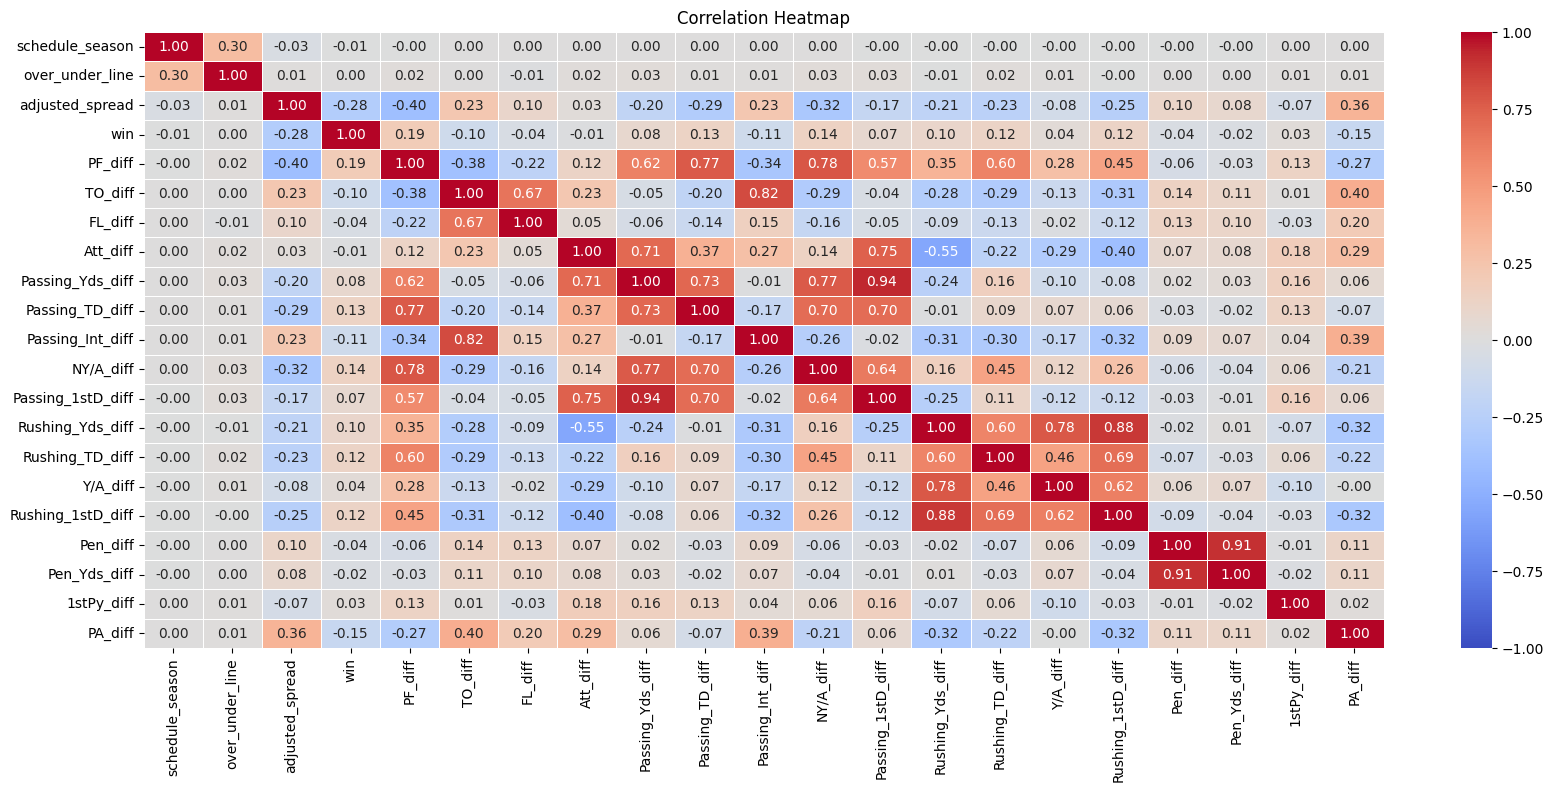

In [343]:
yard_td_pf_cols = ['Rushing_Yds_diff', 'Passing_Yds_diff', 'Rushing_TD_diff', 'Passing_TD_diff', 'PF_diff']

yard_td_pf_df = adj_spread_df[yard_td_pf_cols]

sns.pairplot(yard_td_pf_df, kind='reg', plot_kws={'scatter': False})

corr_matrix = adj_spread_df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()
adj_spread_df = adj_spread_df.drop(columns=['Passing_Int_diff', 'Pen_diff', 'NY/A_diff'])


To address issues with collinearity and the relatively large number of dimensions, I decided to break down the data into different principal components using PCA.

In [344]:

X = adj_spread_df.drop(columns=['win'])
y = adj_spread_df['win']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

pca = PCA(n_components=10) 
spreadPCA = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(spreadPCA, columns=[f'PC{i+1}' for i in range(spreadPCA.shape[1])])


Iterating through different component numbers in PCA while using a simple Logistic Regression model, I plotted the accuracy scores for various component counts. From this experiment, I found that n = 10 components seems to provide the best balance, yielding optimized performance. 

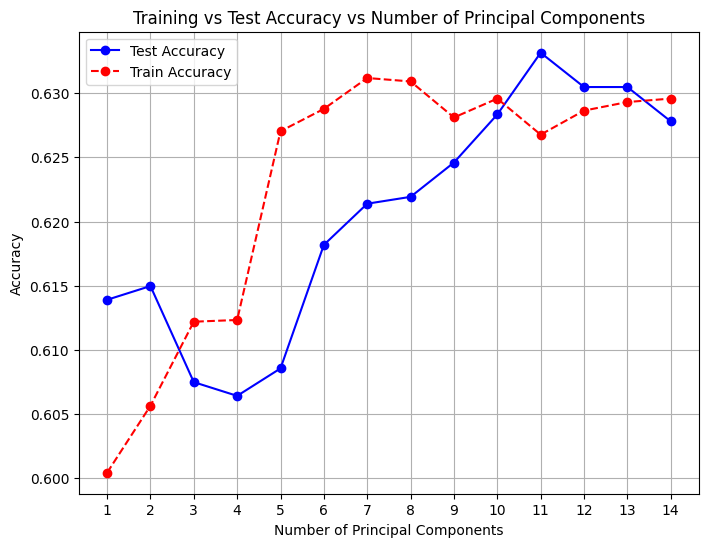

In [345]:
acc = []
train_acc = []

# Loop through different numbers of principal components (1 to 10)
for n in range(1, 15):
    # Apply PCA with n components
    pca = PCA(n_components=n) 
    spreadPCA = pca.fit_transform(scaled_data)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(spreadPCA, columns=[f'PC{i+1}' for i in range(spreadPCA.shape[1])])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=42)

    # Train a RandomForest model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_test = model.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred_test))

    # Make predictions on the training set
    y_pred_train = model.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_pred_train))

# Plot the accuracy for both test and training sets
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15), acc, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.plot(range(1, 15), train_acc, marker='o', linestyle='--', color='r', label='Train Accuracy')
plt.title('Training vs Test Accuracy vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.xticks(range(1, 15))
plt.legend()
plt.grid(True)
plt.show()

I decided to iterate through different numbers of minimum sample leaves in a Random Forest model to determine the best value for this parameter. After testing various values, the results seemed to converge around a minimum sample leaf size of 350.

In [346]:
pca = PCA(n_components=10) 
spreadPCA = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(spreadPCA, columns=[f'PC{i+1}' for i in range(spreadPCA.shape[1])])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=42)
acc = []
train_acc = []
for n in range(1, 1000, 50):
    # Train a RandomForest model
    model = RandomForestClassifier(random_state=42, min_samples_leaf=n)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_test = model.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred_test))

    # Make predictions on the training set
    y_pred_train = model.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_pred_train))



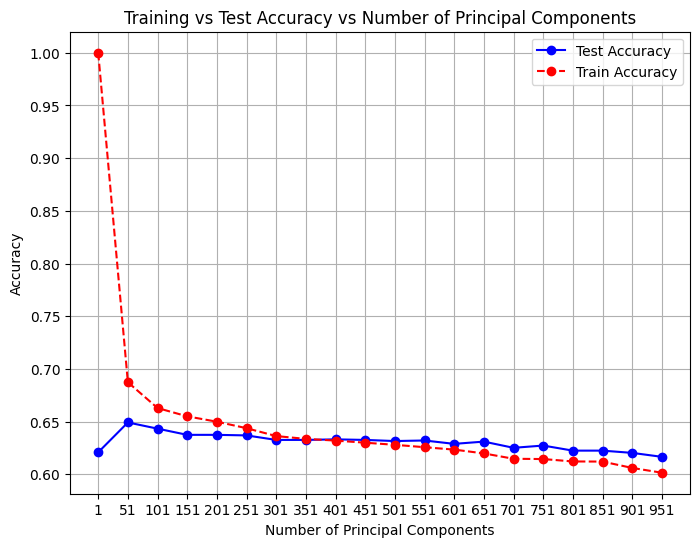

In [347]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 1000, 50), acc, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.plot(range(1, 1000, 50), train_acc, marker='o', linestyle='--', color='r', label='Train Accuracy')
plt.title('Training vs Test Accuracy vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.xticks(range(1, 1000, 50))
plt.legend()
plt.grid(True)
plt.show()

Now we do the same thing with a Logistic Regression model. C = 0.0033 seems to be a good parameter.

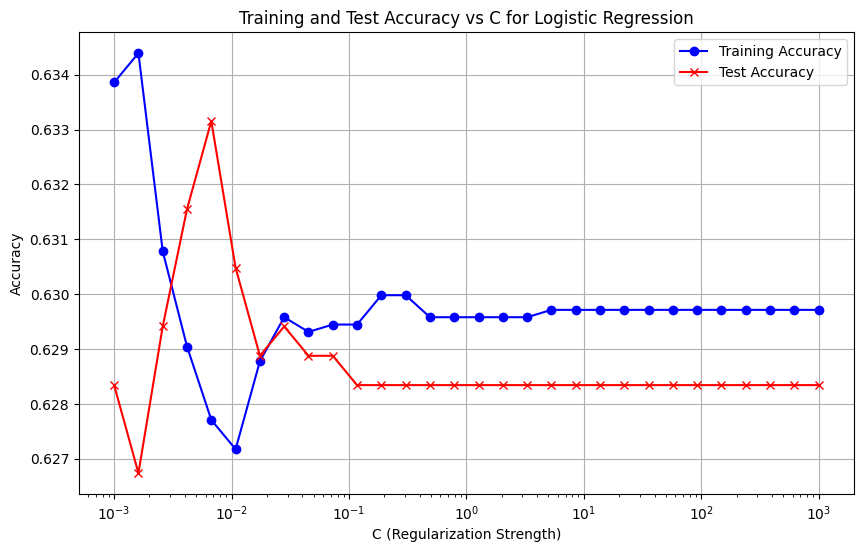

In [348]:
C_values = np.logspace(-3, 3, 30)  

train_acc = []
test_acc = []

for C in C_values:

    log_reg = LogisticRegression(C=C, random_state=42, max_iter=1000)
    log_reg.fit(X_train, y_train)
    
    train_pred = log_reg.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_pred))
    
    test_pred = log_reg.predict(X_test)
    test_acc.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 6))
plt.plot(C_values, train_acc, label="Training Accuracy", color='b', marker='o')
plt.plot(C_values, test_acc, label="Test Accuracy", color='r', marker='x')
plt.xscale('log')  
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs C for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

Through a similar approach, I reached to the conclusion that k = 25 is the best.

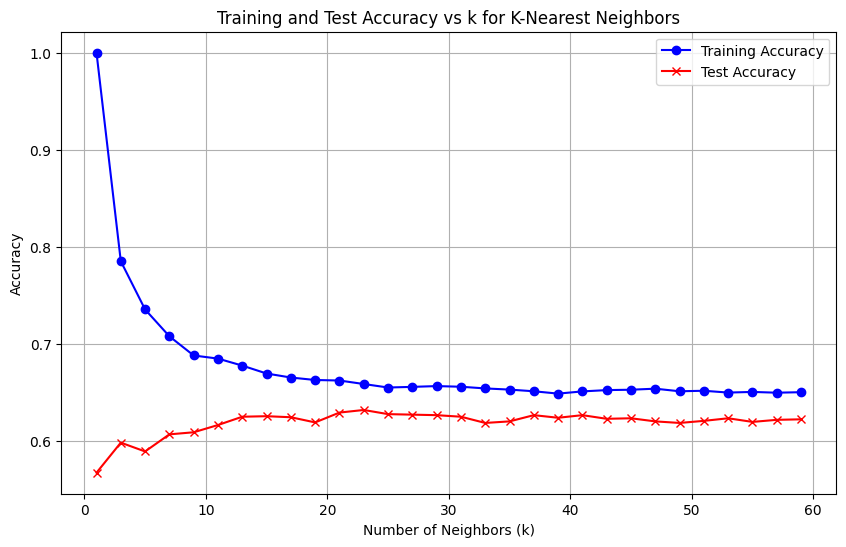

In [349]:
neighbors_values = np.arange(1, 61, 2) 

train_acc = []
test_acc = []

for n_neighbors in neighbors_values:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    knn_model.fit(X_train, y_train)
    
    train_pred = knn_model.predict(X_train)
    train_acc.append(accuracy_score(y_train, train_pred))
    
    test_pred = knn_model.predict(X_test)
    test_acc.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, train_acc, label="Training Accuracy", color='b', marker='o')
plt.plot(neighbors_values, test_acc, label="Test Accuracy", color='r', marker='x')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs k for K-Nearest Neighbors')
plt.legend()
plt.grid(True)
plt.show()


Going back to iterating through different PCA component numbers with more optimized parameters from the previous steps, we can observe that Logistic Regression outperforms the other two models. It tends to get more accurate with a larger number of components, but this might be due to overfitting. Additionally, having a very large k value for KNN can lead to longer computation times, and important features may be muted out in the process. Based on these observations, using 6 components for PCA seems more suitable, as it strikes a balance between model performance and computational efficiency.

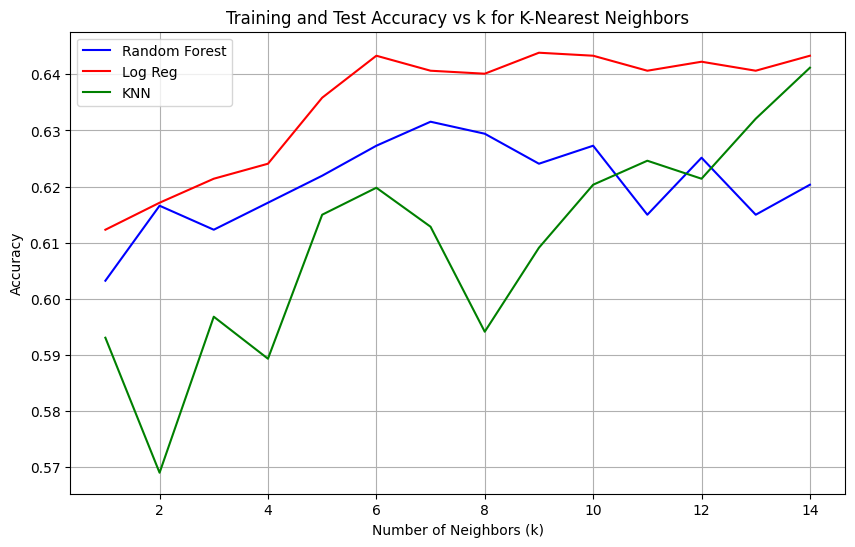

In [350]:
rfc_acc = []
log_acc = []
knn_acc = []

for n in range(1, 15):
    pca = PCA(n_components=n) 
    spreadPCA = pca.fit_transform(scaled_data)

    pca_df = pd.DataFrame(spreadPCA, columns=[f'PC{i+1}' for i in range(spreadPCA.shape[1])])

    X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=2)

    rfc_fin = RandomForestClassifier(random_state=42, min_samples_leaf=350)
    rfc_fin.fit(X_train, y_train)
    log_reg_fin = LogisticRegression(C=0.0033, random_state=42, max_iter=1000)
    log_reg_fin.fit(X_train, y_train)
    knn_model_fin = KNeighborsClassifier(n_neighbors=25)
    knn_model_fin.fit(X_train, y_train)

    rfc_acc.append(accuracy_score(y_test, rfc_fin.predict(X_test)))
    log_acc.append(accuracy_score(y_test, log_reg_fin.predict(X_test)))
    knn_acc.append(accuracy_score(y_test, knn_model_fin.predict(X_test)))


plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), rfc_acc, label="Random Forest", color='b')
plt.plot(range(1, 15), log_acc, label="Log Reg", color='r')
plt.plot(range(1, 15), knn_acc, label="KNN", color='g')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [351]:

rfc = []
log = []
knn = []


pca = PCA(n_components=6) 
spreadPCA = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(spreadPCA, columns=[f'PC{i+1}' for i in range(spreadPCA.shape[1])])
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=2)

rfc_fin = RandomForestClassifier(random_state=42, min_samples_leaf=350)
rfc_fin.fit(X_train, y_train)
log_reg_fin = LogisticRegression(C=C_values[3], random_state=42, max_iter=1000)
log_reg_fin.fit(X_train, y_train)
knn_model_fin = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model_fin.fit(X_train, y_train)

rfc_pca = (accuracy_score(y_test, rfc_fin.predict(X_test)))
log_pca = (accuracy_score(y_test, log_reg_fin.predict(X_test)))
knn_pca = (accuracy_score(y_test, knn_model_fin.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
rfc_fin = RandomForestClassifier(random_state=42, min_samples_leaf=350)
rfc_fin.fit(X_train, y_train)
log_reg_fin = LogisticRegression(C=C_values[3], random_state=42, max_iter=1000)
log_reg_fin.fit(X_train, y_train)
knn_model_fin = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model_fin.fit(X_train, y_train)
rfc_norm = (accuracy_score(y_test, rfc_fin.predict(X_test)))
log_norm  = (accuracy_score(y_test, log_reg_fin.predict(X_test)))
knn_norm  = (accuracy_score(y_test, knn_model_fin.predict(X_test)))


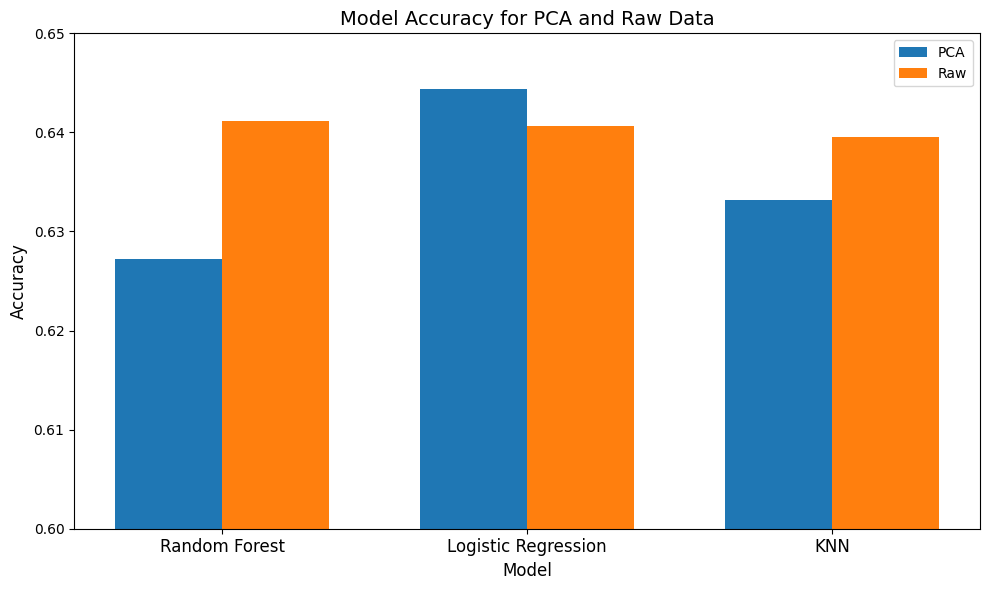

In [352]:

models = ['Random Forest', 'Logistic Regression', 'KNN']
pca_acc = [rfc_pca, log_pca, knn_pca]
norm_acc = [rfc_norm, log_norm, knn_norm]

bar_width = 0.35 
index = np.arange(len(models)) 

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, pca_acc, bar_width, label='PCA')
bar2 = ax.bar(index + bar_width, norm_acc, bar_width, label='Raw')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Accuracy for PCA and Raw Data', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, fontsize=12)
ax.legend()
ax.set_ylim(0.6, 0.65)

plt.tight_layout()
plt.show()


It was a big surprise to discover that only the logistic regression method performed better with PCA. Random forest performed better without PCA, which could be explained by the fact that reducing dimensions impaired the random forest's ability to classify with a large number of features. It could also be due to a lack of data points, which may not have provided enough correlations for the random forest to work effectively. Reducing collinearity within features may have helped the logistic regression model create a simpler, linear relationship among the principal components. Reducing dimensions and distorting them through PCA could have impacted the distance between data points, making it harder for KNN to perform well.

In conclusion, the logistic regression model seems to perform the best in this scenario. Its simplicity likely aligns well with the collinear nature of many features, which made it an effective choice for this task. It is possible that the random forest and KNN models didn’t perform as well due to the limited data points, which may not have been enough for these more complex models to fully realize their potential.

Looking ahead, I believe introducing more complex features, such as individual player statistics and weather data, could provide valuable insights and improve the model’s performance. The next step involves gathering individual player data and linking it to each game and spread, which I hope will add significant predictive value to the model.

While I have considered transitioning to basketball models, due to the simpler structure of the sport and larger datasets, I am still focused on refining the NFL model for now. The fact that my current logistic regression model was able to achieve an accuracy above 60%, with the best result nearing 65%, was a pleasant surprise. With continued feature engineering and model adjustments, I am optimistic that performance can be further improved.